In [1]:
from typing import List, Mapping
from itertools import zip_longest
from glob import iglob

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [41]:
!ls /data/*/Run_203/work/*.h5

/data/Step501N2/Run_203/work/Run_203.h5


/data/Step501N2/Run_203/work/Run_203.h5


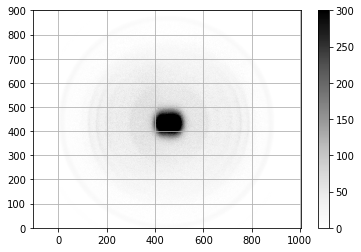

In [35]:
run = 203
filename = next(iglob(f"/data/*/Run_{run:03d}/work/Run_{run:03d}.h5"))
print(filename)

with File(filename, "r") as f:
    img = f["vmi_sum"][...]

plt.figure()
plt.pcolormesh(img.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 300)
plt.show()

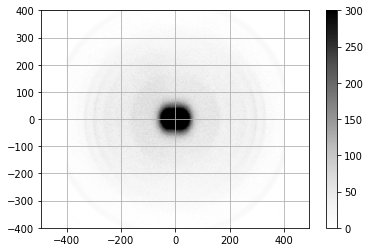

In [39]:
xn, yn = img.shape
xedges = np.arange(xn + 1)
yedges = np.arange(yn + 1)
f = interp(img, xedges, yedges)
g = transpose_linearly(f, np.eye(2), x0=np.array([459,432, ]))
zedges = np.arange(-400, 400 + 1)
transformed = tohist(g, zedges, zedges)

plt.figure()
plt.pcolormesh(zedges, zedges, transformed.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 300)
plt.show()

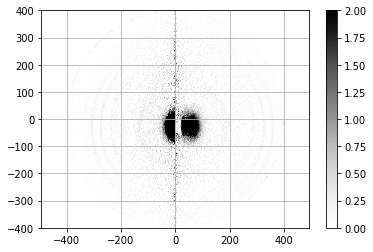

In [37]:
# Abel invert the image
z = (zedges[1:] + zedges[:-1]) / 2
xx, yy = np.meshgrid(z, z, indexing='ij')
rr = (xx ** 2 + yy ** 2) ** 0.5
clean = transformed.copy()
clean[400 < rr] = 0
dz = zedges[1:] - zedges[:-1]
inverted = abel_inverse(clean, zedges) * dz[None, :]  # shape: (r, z)

plt.figure()
plt.pcolormesh(zedges, zedges, inverted.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 2)
plt.show()

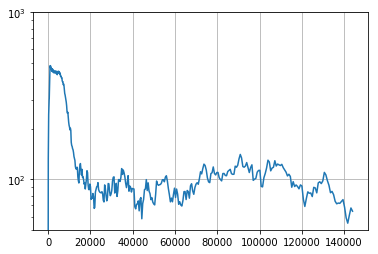

In [38]:
# Transpose to other spaces
sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
redges, thedges = np.linspace(0, 380, 381), np.linspace(-np.pi, np.pi, 361)
hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
_, coeff, _ = finite_legendre_transform_in_theta(
    hist_indrdomega.sum(0), thedges, 6,
)  # Shapes of returns: (n, r) (n, r) (n, th)

r = (redges[1:] + redges[:-1]) / 2

plt.figure()
# plt.plot(r, hist_indrdth.sum(1))
plt.plot(r**2, hist_indrdth.sum(1)/2/r)
plt.yscale("log")
plt.ylim(5e1, 1e3)
plt.grid()
plt.show()